# Sentiment Analysis in Python

In this notebook we will be doing some sentiment analysis in python using two different techniques:

VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
Roberta Pretrained Model from Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [87]:
import pandas as pd                             # 8 Processors 2.2 GHz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [88]:
# Read in data
df = pd.read_csv('/content/drive/MyDrive/Instagram threads.csv')
print(df.shape)


#Downscale
df = df.head(100)
print(df.shape)

(36943, 14)
(100, 14)


In [89]:
# List of columns to drop
columns_to_drop = ['source', 'review_id', 'user_name', 'review_title', 'thumbs_up',
                   'review_date', 'developer_response', 'developer_response_date',
                   'appVersion', 'laguage_code', 'country_code']

# Drop the specified columns from the DataFrame
df_cleaned = df.drop(columns=columns_to_drop)

# Display the cleaned DataFrame
print(df_cleaned.shape)

(100, 3)


In [90]:
df_cleaned.head(100)

,Unnamed: 0,review_description,rating
0,0,Good,5
1,1,Weak copy of Twitter,1
2,2,i wish threads have a save button for images a...,3
3,3,Love it,5
4,4,Very god,5
...,...,...,...
95,95,It's a waste of time,1
96,96,Follow me,5
97,97,Poor add download they misbehave afterwards,1
98,98,Too many bugs.. Twitter is better,1


In [91]:
df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

# Now 'df' will have the column name changed from 'Unnamed: 0' to 'index'
print(df.head())

   index       source                             review_id  \
0      0  Google Play  7cd90e5b-4829-43b9-9fb4-c8c6d1e339c1   
1      1  Google Play  6deb8265-2bac-4524-bcb6-f90829fa4e69   
2      2  Google Play  91ef61ce-0f05-4f3b-b3d3-5d19cd408ab8   
3      3  Google Play  b7721b78-6b77-4f8c-a1d3-a854af4c1f0f   
4      4  Google Play  c89ef522-c94c-4171-878f-1d672dce7f11   

                    user_name review_title  \
0             Eddie Clark Jr.          NaN   
1                     Rasa RT          NaN   
2  SITI NUR HAFIZA BINTI AZIZ          NaN   
3               Asap Khalifah          NaN   
4                Syed Hussein          NaN   

                                  review_description  rating  thumbs_up  \
0                                               Good       5        0.0   
1                               Weak copy of Twitter       1        0.0   
2  i wish threads have a save button for images a...       3        0.0   
3                                           

# Quick EDA

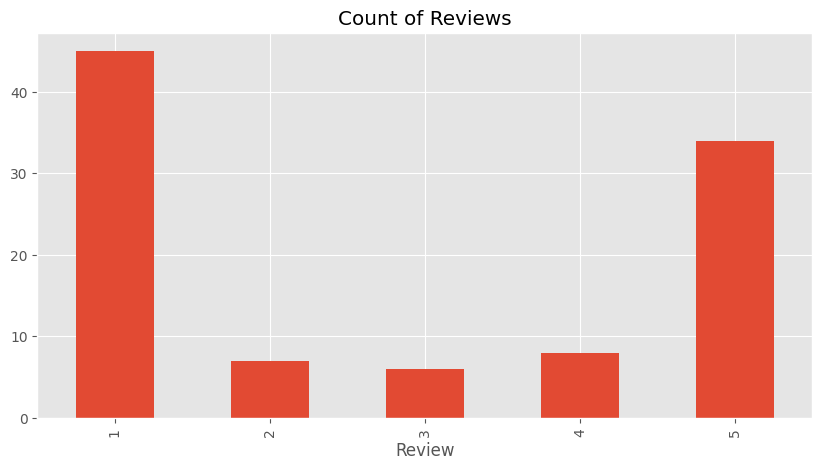

In [92]:
ax = df['rating'].value_counts().sort_index() \
          .plot(kind='bar',
          title='Count of Reviews',
          figsize=(10, 5))
ax.set_xlabel('Review')
plt.show()

# Basic NLTK

In [93]:
example = df['review_description'][46]
print(example)

An exciting new way to see Ads and posts from people you don't care about! At least you don't have to worry about seeing up any preferences.


In [95]:
tokens = nltk.word_tokenize(example)
tokens[:12]

['An',
 'exciting',
 'new',
 'way',
 'to',
 'see',
 'Ads',
 'and',
 'posts',
 'from',
 'people',
 'you']

In [96]:
tagged = nltk.pos_tag(tokens)
tagged[-5:]

[('seeing', 'VBG'),
 ('up', 'RP'),
 ('any', 'DT'),
 ('preferences', 'NNS'),
 ('.', '.')]

In [97]:
entities = nltk.chunk.ne_chunk(tagged)
print(entities)

(S
  An/DT
  exciting/JJ
  new/JJ
  way/NN
  to/TO
  see/VB
  (PERSON Ads/NNP)
  and/CC
  posts/NNS
  from/IN
  people/NNS
  you/PRP
  do/VBP
  n't/RB
  care/VB
  about/IN
  !/.
  At/IN
  least/JJS
  you/PRP
  do/VBP
  n't/RB
  have/VB
  to/TO
  worry/VB
  about/IN
  seeing/VBG
  up/RP
  any/DT
  preferences/NNS
  ./.)


# Step 1. VADER Seniment Scoring

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

(Valence Aware Dictionary and sEntiment Reasoner)

This uses a "bag of words" approach:
Stop words are removed
each word is scored and combined to a total score.


In [98]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [99]:
sia.polarity_scores('The curious cat jumped over the lazy dog and landed gracefully on the fluffy pillow.')

{'neg': 0.124, 'neu': 0.594, 'pos': 0.282, 'compound': 0.4939}

In [100]:
sia.polarity_scores('True friends are like stars; even in the darkest of times, they shine brightly and guide us..')

{'neg': 0.123, 'neu': 0.46, 'pos': 0.418, 'compound': 0.7717}

In [101]:
print(example)
sia.polarity_scores(example)

An exciting new way to see Ads and posts from people you don't care about! At least you don't have to worry about seeing up any preferences.


{'neg': 0.081, 'neu': 0.738, 'pos': 0.181, 'compound': 0.5057}

In [102]:
extdata = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review_description']
    myid = row['rating']
    extdata[myid] = sia.polarity_scores(text)

  0%|          | 0/100 [00:00<?, ?it/s]

In [103]:
vaders = pd.DataFrame(extdata).T
vaders = vaders.reset_index().rename(columns={'index': 'rating'})
vaders = vaders.merge(df, how='left')


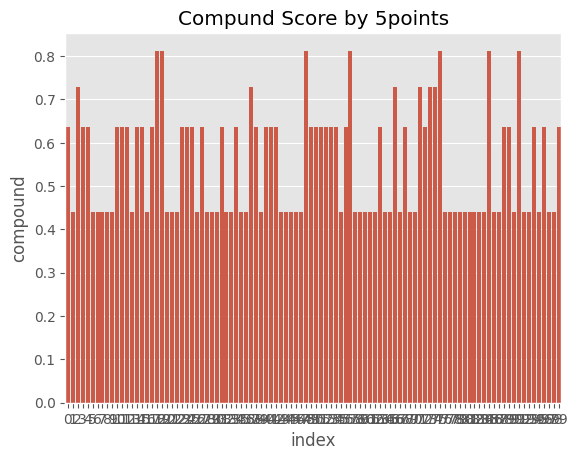

In [104]:
ax = sns.barplot(data=vaders, x='index', y='compound')
ax.set_title('Compund Score by 5points')
plt.show()

# Plot VADER results

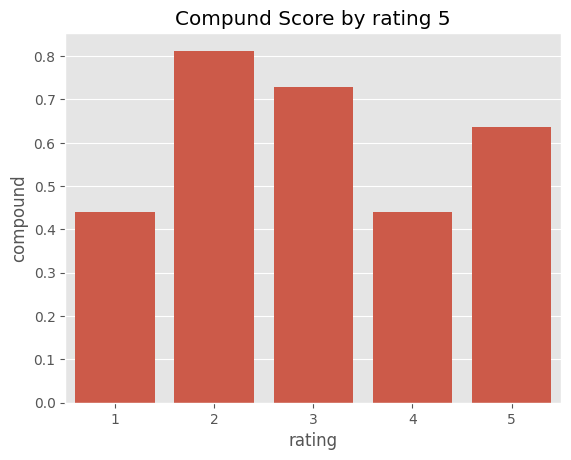

In [105]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score by rating 5')
plt.show()

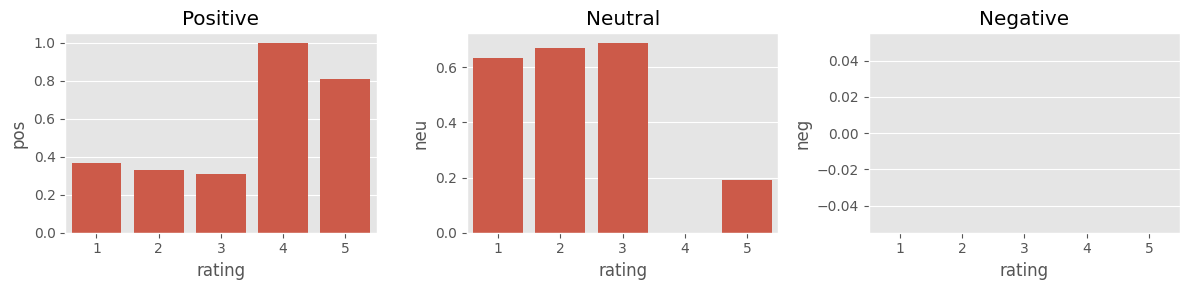

In [106]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 2. Roberta Pretrained Model
Use a model trained of a large corpus of data.
Transformer model accounts for the words but also the context related to other words.

In [107]:
print(example)

An exciting new way to see Ads and posts from people you don't care about! At least you don't have to worry about seeing up any preferences.


In [108]:
# VADER results on example
print(example)
sia.polarity_scores(example)

An exciting new way to see Ads and posts from people you don't care about! At least you don't have to worry about seeing up any preferences.


{'neg': 0.081, 'neu': 0.738, 'pos': 0.181, 'compound': 0.5057}

In [109]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [110]:
data_t = f"cardiffnlp/twitter-roberta-base-sentiment"  #1.5L sentences 3 1.7 Trillion
tokenizer = AutoTokenizer.from_pretrained(data_t)
model = AutoModelForSequenceClassification.from_pretrained(data_t)

In [111]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
#print(encoded_text)
output = model(**encoded_text)
print(output)
print("-----------------------------")
scores = output[0][0].detach().numpy()
print(scores)
scores = softmax(scores)
print(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

SequenceClassifierOutput(loss=None, logits=tensor([[-0.5279,  0.1152,  0.6536]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
-----------------------------
[-0.5279186  0.1151512  0.6536087]
[0.16229394 0.30873364 0.52897245]
{'roberta_neg': 0.16229394, 'roberta_neu': 0.30873364, 'roberta_pos': 0.52897245}


In [112]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
#print(encoded_text)
output = model(**encoded_text)
print(output)
print("-----------------------------")
scores = output[0][0].detach().numpy()
print(scores)
scores = softmax(scores)
print(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

SequenceClassifierOutput(loss=None, logits=tensor([[-0.5279,  0.1152,  0.6536]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
-----------------------------
[-0.5279186  0.1151512  0.6536087]
[0.16229394 0.30873364 0.52897245]
{'roberta_neg': 0.16229394, 'roberta_neu': 0.30873364, 'roberta_pos': 0.52897245}


In [122]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [124]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review_description']
        myid = row['rating']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value

        roberta_result = polarity_scores_roberta(text)

        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/100 [00:00<?, ?it/s]

In [125]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'review_description': 'rating'})
results_df = results_df.merge(df, how='left')
results_df.head()

,index,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,source,review_id,...,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,5,0.0,0.192,0.808,0.6369,0.012817,0.180937,0.806246,Google Play,950acab8-bc92-4e1e-81c4-3f228ccc7362,...,NaN,Nice,1,0.0,2023-08-07 18:03:09,NaN,NaN,NaN,en,us
1,1,0.0,0.633,0.367,0.4404,0.446364,0.368028,0.185608,Google Play,6deb8265-2bac-4524-bcb6-f90829fa4e69,...,NaN,Weak copy of Twitter,1,0.0,2023-08-07 19:07:04,NaN,NaN,NaN,en,us
2,3,0.0,0.689,0.311,0.7291,0.003242,0.023324,0.973434,Google Play,b7721b78-6b77-4f8c-a1d3-a854af4c1f0f,...,NaN,Love it,5,0.0,2023-08-07 18:37:16,NaN,NaN,NaN,en,us
3,2,0.0,0.670,0.330,0.8126,0.308370,0.495720,0.195911,Google Play,91ef61ce-0f05-4f3b-b3d3-5d19cd408ab8,...,NaN,i wish threads have a save button for images a...,3,0.0,2023-08-07 18:57:07,NaN,NaN,294.0.0.27.110,en,us
4,4,0.0,0.000,1.000,0.4404,0.126004,0.559926,0.314070,Google Play,c89ef522-c94c-4171-878f-1d672dce7f11,...,NaN,Very god,5,0.0,2023-08-07 18:14:15,NaN,NaN,NaN,en,us


# Compare Scores between models

In [126]:
results_df.columns

Index(['index', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'source', 'review_id',
       'user_name', 'review_title', 'review_description', 'rating',
       'thumbs_up', 'review_date', 'developer_response',
       'developer_response_date', 'appVersion', 'laguage_code',
       'country_code'],
      dtype='object')

In [127]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'rating'})
results_df = results_df.merge(df, how='left')
results_df.head()

,rating,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,index,source,...,user_name,review_title,review_description,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,5,0.0,0.192,0.808,0.6369,0.012817,0.180937,0.806246,0,Google Play,...,Eddie Clark Jr.,NaN,Good,0.0,2023-08-07 19:14:36,NaN,NaN,294.0.0.27.110,en,us
1,5,0.0,0.192,0.808,0.6369,0.012817,0.180937,0.806246,3,Google Play,...,Asap Khalifah,NaN,Love it,0.0,2023-08-07 18:37:16,NaN,NaN,NaN,en,us
2,5,0.0,0.192,0.808,0.6369,0.012817,0.180937,0.806246,4,Google Play,...,Syed Hussein,NaN,Very god,0.0,2023-08-07 18:14:15,NaN,NaN,NaN,en,us
3,5,0.0,0.192,0.808,0.6369,0.012817,0.180937,0.806246,10,Google Play,...,Deborah Black,NaN,I love it 💞,0.0,2023-08-07 17:22:27,NaN,NaN,294.0.0.27.110,en,us
4,5,0.0,0.192,0.808,0.6369,0.012817,0.180937,0.806246,11,Google Play,...,Faisal Pathan,NaN,Osm,0.0,2023-08-07 16:29:58,NaN,NaN,294.0.0.27.110,en,us


In [131]:
#JUST TO UNDERSTAND

vader_r_rename = {'va': 1, 'vb': 2}
roberta_r = {'rb': 3, 'rc': 4}

both = {**vader_r_rename, **roberta_r}

print(both)

{'va': 1, 'vb': 2, 'rb': 3, 'rc': 4}


In [132]:
print(results_df.columns)


Index(['rating', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'index', 'source',
       'review_id', 'user_name', 'review_title', 'review_description',
       'thumbs_up', 'review_date', 'developer_response',
       'developer_response_date', 'appVersion', 'laguage_code',
       'country_code'],
      dtype='object')


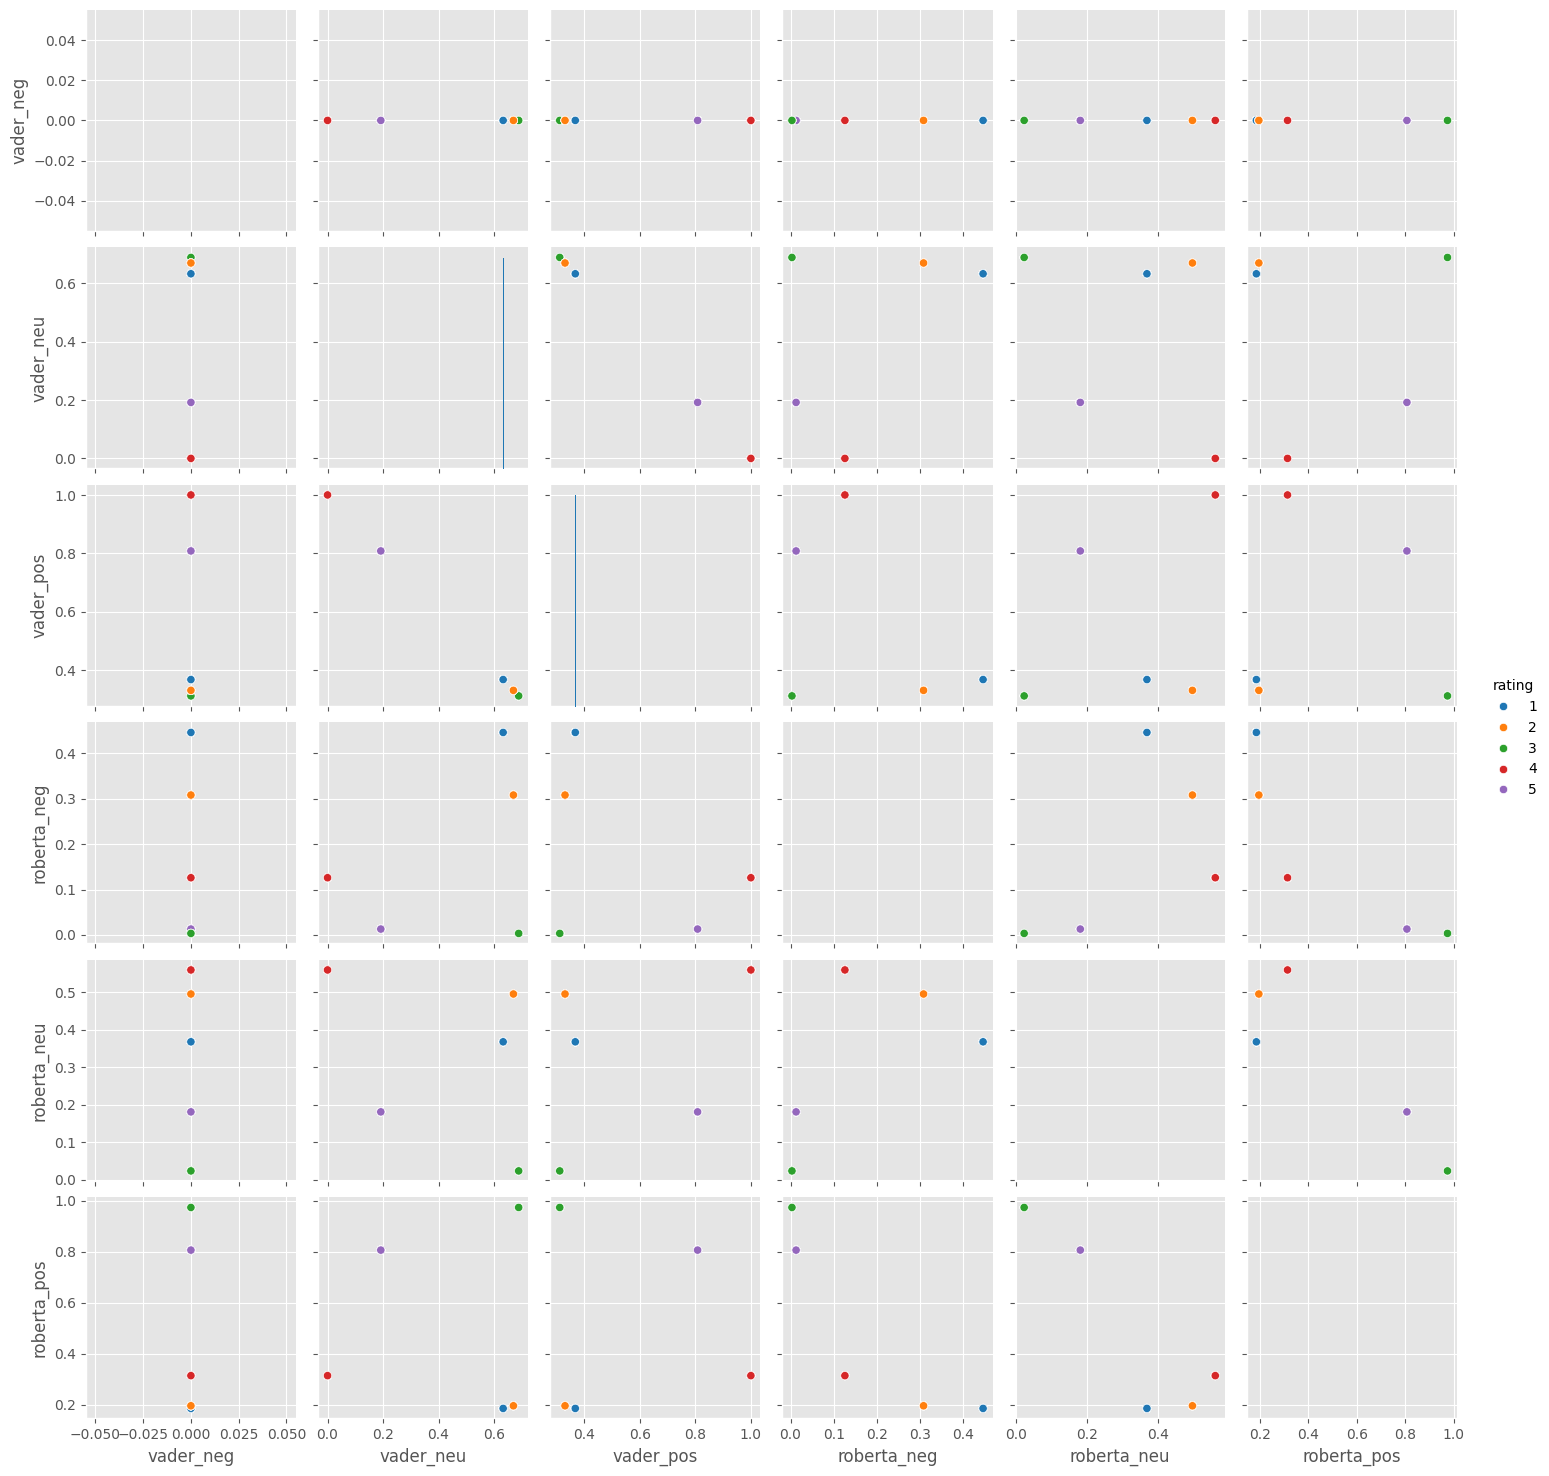

In [135]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                   'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='rating',
             palette='tab10')
plt.show()

# Step 4: Review Examples:
Positive 1-Star and Negative 5-Star Reviews
Lets look at some examples where the model scoring and review score differ the most.



In [137]:
results_df.query('index == 1') \
    .sort_values('roberta_pos', ascending=False)['review_description'].values[0]

'Weak copy of Twitter'

In [138]:
results_df.query('index == 1') \
    .sort_values('roberta_pos', ascending=False)['review_description'].values[0]

'Weak copy of Twitter'

In [140]:
results_df.query('index == 1') \
    .sort_values('vader_pos', ascending=False)['review_description'].values[0]

'Weak copy of Twitter'

In [141]:
results_df.query('index == 4') \
    .sort_values('roberta_neg', ascending=False)['review_description'].values[0]

'Very god'

In [142]:
results_df.query('index == 4') \
    .sort_values('vader_neg', ascending=False)['review_description'].values[0]

'Very god'